# Hyperparameter Optimization (HPO)

## Objective:
In this lab, you will learn to use [Optuna](https://optuna.org/) to fine-tune a [CatBoost](https://catboost.ai/docs/en/concepts/python-quickstart) model on the [Covertype Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html). The objective is to maximize classification accuracy by finding the best hyperparameter combination for this multiclass classification problem.

## 1. Installing Necessary Packages

To get started, install the required Python packages by running the following command in your terminal or command prompt:

```bash
pip install optuna catboost pandas scikit-learn optuna-dashboard seaborn matplotlib
```

What’s Installed:
- Optuna: For hyperparameter optimization.
- CatBoost: The gradient boosting library we’ll tune.
- Pandas: For data manipulation.
- Scikit-learn: For dataset loading and evaluation metrics.
- Optuna-dashboard: For real-time monitoring of optimization.
- Seaborn & Matplotlib: For data visualizations.

## 2. Loading the Covertype Dataset
The Covertype dataset is a multiclass classification task with 54 features, 7 classes, and over 500,000 samples. We’ll load it directly using Scikit-learn’s `fetch_covtype` function.

In [26]:
from sklearn.datasets import fetch_covtype
import pandas as pd

# Load the dataset
covtype = fetch_covtype(as_frame=True)  # Returns a DataFrame
X = covtype.data  # Features
y = covtype.target - 1  # Target (adjusted to 0-6 for zero-based indexing)

Why Covertype?
- Multiclass Complexity: Predicts 7 forest cover types.
- Mixed Features: Includes both numerical and categorical (binary) features, perfect for CatBoost.
- Large Scale: Tests model performance on a substantial dataset.

To make computations faster, we'll take into account only 20k samples.

In [27]:
sample_size = 20000
# Ensure we get a balanced sample across all classes
from sklearn.model_selection import train_test_split
X_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=sample_size, random_state=42, stratify=y
)
X = X_sample
y = y_sample

## 3. Visualizing the Dataset
Visualizations help us understand the data before modeling. Below are three useful plots:

### Class Distribution
Examine the balance of classes in the target variable.

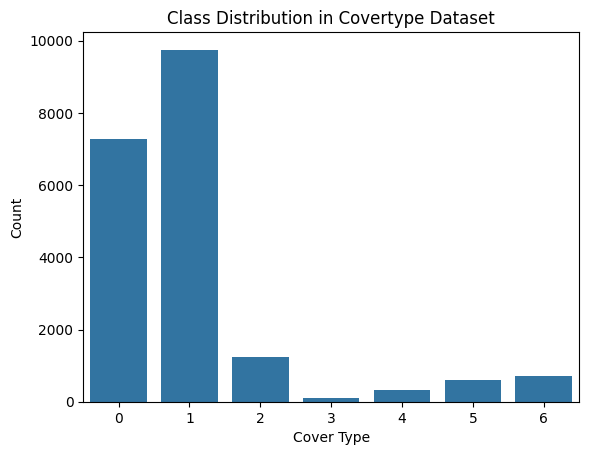

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title('Class Distribution in Covertype Dataset')
plt.xlabel('Cover Type')
plt.ylabel('Count')
plt.show()

### Feature Correlation Heatmap
Check correlations among the first 10 features.

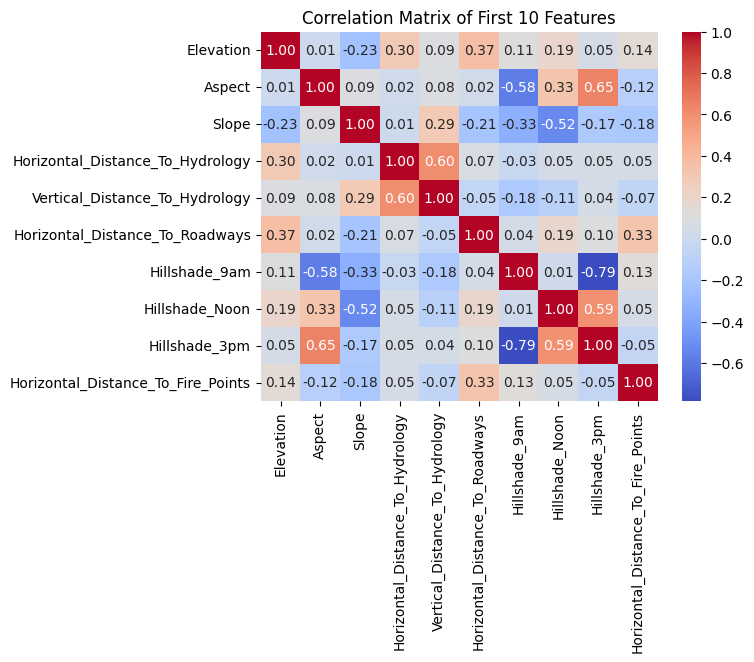

In [29]:
# Select first 10 features for simplicity
subset = X.iloc[:, :10]

# Compute correlation matrix
corr = subset.corr()

# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of First 10 Features')
plt.show()

### Pairplot for Selected Features
Visualize relationships between the first 3 features and class separation.

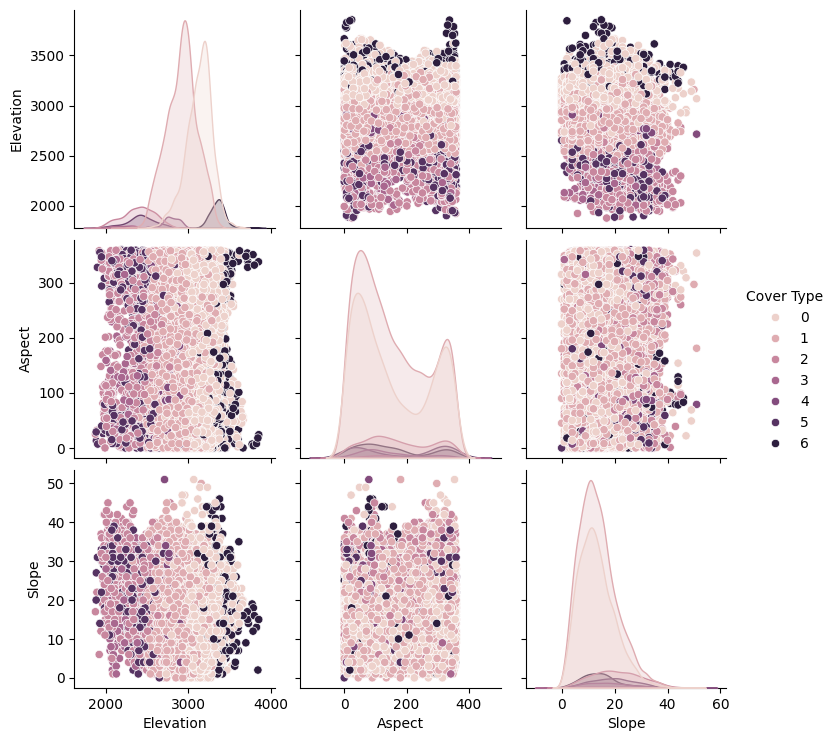

In [30]:
# Combine features and target for a sample
sample = X.iloc[:, :3].copy()  # First 3 features
sample['Cover Type'] = y

sns.pairplot(sample, hue='Cover Type', diag_kind='kde')
plt.show()

## 4. Train and evaluate CatBoost with default settings

Before performing hyperparameter optimization, it’s important to establish a baseline model using CatBoost with default settings. This helps us gauge how much improvement is achieved through tuning.

In [31]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the dataset into training, validation and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Initialize the CatBoost model with default settings
model = CatBoostClassifier(verbose=0, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
baseline_accuracy = accuracy_score(y_test, y_pred)

print(f"Baseline Accuracy: {baseline_accuracy * 100:.2f}%")

Baseline Accuracy: 83.43%


Confusion matrices are great for understanding the model's performance on a per-class basis. They provide detailed insight into which classes are being confused with each other, allowing you to identify weaknesses in the model’s predictions.

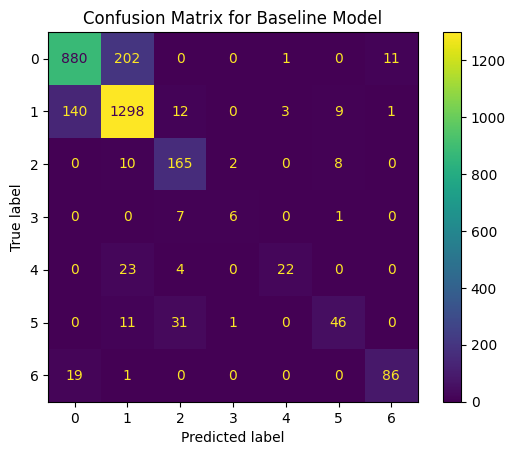

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Confusion Matrix for Baseline Model')
plt.show()

## 5. Implementing Hyperparameter Tuning with Optuna
The objective function drives the optimization:
- Takes a trial object from Optuna.
- Suggests hyperparameter values.
- Trains a CatBoost model.
- Evaluates accuracy on the validation set.
- Returns the score (accuracy).

This [notebook](https://github.com/optuna/optuna-examples/blob/main/quickstart.ipynb) provides a useful example of implementing Optuna, although it employs cross-validation (CV) rather than a train/validation split. Additionally, the CatBoost documentation [page](https://catboost.ai/docs/en/concepts/parameter-tuning) offers comprehensive guidance on parameter tuning.

In [33]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0,
        'random_state': 42
    }

    # Use StratifiedKFold for Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize the CatBoost model
    model = CatBoostClassifier(**params)

    # Perform cross-validation and calculate the mean accuracy
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy', n_jobs=-1)

    # Return the mean accuracy as the objective value
    return cv_scores.mean()

Set up and run the Optuna study:

In [34]:
# Create the study
study_name = 'catboost_optimization'
storage_name = 'sqlite:///example.db' 
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    direction='maximize',
    load_if_exists=True
)
study.optimize(objective, n_trials=20)  # Run 20 trials

[I 2025-04-07 23:18:51,891] A new study created in RDB with name: catboost_optimization
[I 2025-04-07 23:19:02,881] Trial 0 finished with value: 0.8079000000000001 and parameters: {'iterations': 566, 'learning_rate': 0.03486416092851489, 'depth': 7, 'l2_leaf_reg': 0.003286418867192695, 'random_strength': 2.88423794399761, 'bagging_temperature': 0.3265549884259116, 'border_count': 54}. Best is trial 0 with value: 0.8079000000000001.
[I 2025-04-07 23:19:27,577] Trial 1 finished with value: 0.8520999999999999 and parameters: {'iterations': 623, 'learning_rate': 0.21005234031533487, 'depth': 9, 'l2_leaf_reg': 4.946253280326179, 'random_strength': 0.26238659733236847, 'bagging_temperature': 0.0069837164123690565, 'border_count': 79}. Best is trial 1 with value: 0.8520999999999999.
[I 2025-04-07 23:19:31,931] Trial 2 finished with value: 0.8102499999999999 and parameters: {'iterations': 246, 'learning_rate': 0.1118216697550807, 'depth': 6, 'l2_leaf_reg': 0.10294833900210708, 'random_strength

## 6. Setting up Optuna Dashboard
Optuna offers a dashboard to monitor optimization in real-time. Launch it with:

```bash
optuna-dashboard sqlite:///example.db
```
Monitor trials at http://localhost:8080. Discuss results. Which features are most important?

- The most important features are those that have the highest average gain when used in trees. This means they contribute significantly to reducing the loss function during training.
- The least important features are those that have the lowest average gain. They contribute less to the model's performance and can often be removed without significantly affecting the model's accuracy.

On this step optuna does not provide feature importance, but we can use the CatBoost method `get_feature_importance` to get the feature importance of the best model found by Optuna. 

But for hyperparameter tuning, the most important features are those that have the highest average gain when used in trees. We will extract those later.


## 7. Post-Optimization Steps: Analyzing Results and Final Evaluation

After the Optuna study completes, we need to analyze the results, train a final model using the best hyperparameters found, and evaluate its performance on the unseen test set.

In [36]:
# Retrieve the best trial from the study
best_trial = study.best_trial

print(f"Best Trial Number: {best_trial.number}")
print(f"Best Validation Accuracy: {best_trial.value:.4f}")
print("Best Hyperparameters Found:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Best Trial Number: 15
Best Validation Accuracy: 0.8599
Best Hyperparameters Found:
  iterations: 775
  learning_rate: 0.06440556900976803
  depth: 10
  l2_leaf_reg: 0.01766143718740733
  random_strength: 0.00100811584715108
  bagging_temperature: 0.2723992814672218
  border_count: 202


> Note: Review the best hyperparameters found. Do they make sense? Are any parameters hitting the boundaries of their search space (e.g., iterations consistently at 1000)? If so, you might consider expanding the search space in a future run. The "Best Validation Accuracy" is the score Optuna maximized using the validation set within the objective function.

Now, we train a new CatBoost model using the best hyperparameters found by Optuna. Crucially, we train this model on the combination of the original training data and validation data. This allows the final model to learn from more data than any single model trained during the optimization trials.

In [37]:
best_params = best_trial.params

# --- IMPORTANT: Combine Training and Validation Data ---
# Create the full training dataset (train + validation) for the final model
X_train_full = pd.concat([X_train, X_valid], ignore_index=True)
y_train_full = pd.concat([y_train, y_valid], ignore_index=True)

final_params = best_params.copy()
final_params['random_state'] = 42

final_model = CatBoostClassifier(**final_params)
final_model.fit(X_train_full, y_train_full)

0:	learn: 1.7499031	total: 63.4ms	remaining: 49.1s
1:	learn: 1.6077600	total: 97.4ms	remaining: 37.6s
2:	learn: 1.4946322	total: 127ms	remaining: 32.8s
3:	learn: 1.3995087	total: 159ms	remaining: 30.6s
4:	learn: 1.3214543	total: 189ms	remaining: 29.2s
5:	learn: 1.2518188	total: 219ms	remaining: 28.1s
6:	learn: 1.1916794	total: 252ms	remaining: 27.6s
7:	learn: 1.1403896	total: 286ms	remaining: 27.4s
8:	learn: 1.0928829	total: 322ms	remaining: 27.4s
9:	learn: 1.0517209	total: 355ms	remaining: 27.1s
10:	learn: 1.0133584	total: 386ms	remaining: 26.8s
11:	learn: 0.9788729	total: 418ms	remaining: 26.6s
12:	learn: 0.9469147	total: 448ms	remaining: 26.3s
13:	learn: 0.9169497	total: 481ms	remaining: 26.1s
14:	learn: 0.8894640	total: 515ms	remaining: 26.1s
15:	learn: 0.8646856	total: 556ms	remaining: 26.4s
16:	learn: 0.8429990	total: 585ms	remaining: 26.1s
17:	learn: 0.8201204	total: 616ms	remaining: 25.9s
18:	learn: 0.8000025	total: 645ms	remaining: 25.7s
19:	learn: 0.7823343	total: 675ms	remai

This is the moment of truth! We evaluate our optimized `final_model` on the completely unseen X_test and y_test to get an unbiased estimate of its generalization performance. We then compare this to the baseline model's performance on the same test set.

--- Performance Comparison ---
Baseline Accuracy (on Test Set): 83.43%
Optimized Accuracy (on Test Set): 86.10%
Improvement due to HPO: 2.67%
Confusion Matrix for Final Optimized Model (on Test Set):


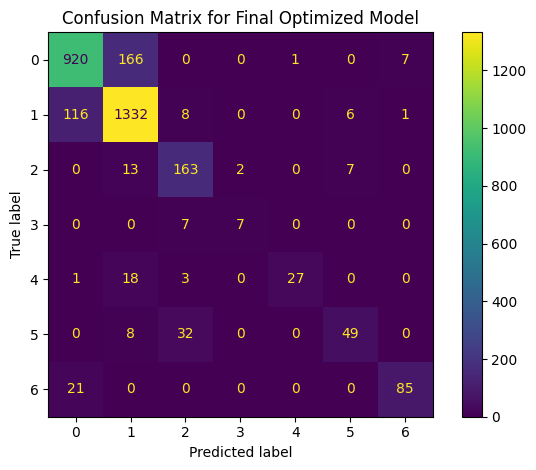

In [38]:
y_pred_test = final_model.predict(X_test)

# Calculate final accuracy
final_accuracy = accuracy_score(y_test, y_pred_test)

print("--- Performance Comparison ---")
# Assuming baseline_accuracy variable holds the score from Step 5
print(f"Baseline Accuracy (on Test Set): {baseline_accuracy * 100:.2f}%")
print(f"Optimized Accuracy (on Test Set): {final_accuracy * 100:.2f}%")
improvement = final_accuracy - baseline_accuracy
print(f"Improvement due to HPO: {improvement * 100:.2f}%")

print("Confusion Matrix for Final Optimized Model (on Test Set):")
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test)
plt.title('Confusion Matrix for Final Optimized Model')
plt.tight_layout()
plt.show()

Finally, let's examine which features the optimized CatBoost model found most important for making predictions.


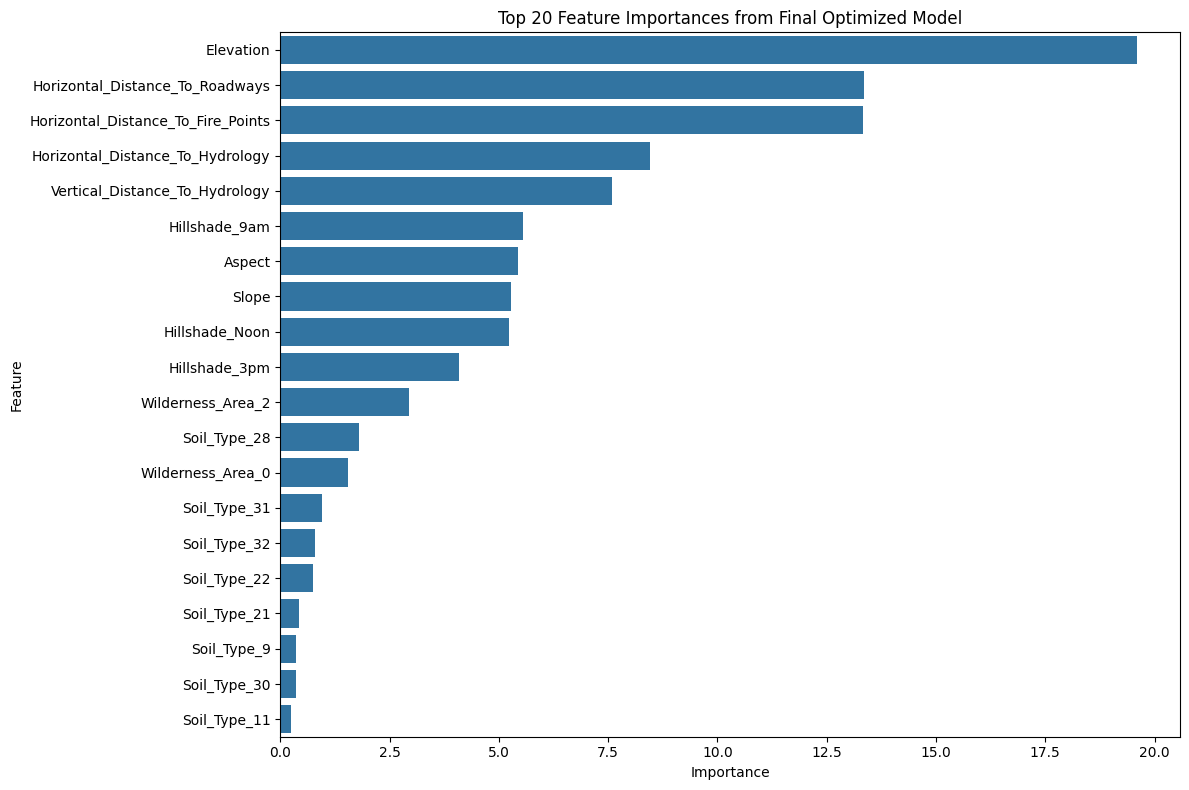

In [39]:
importances = final_model.get_feature_importance()
feature_names = X_train_full.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances (e.g., top 20)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20)) # Plot top 20
plt.title('Top 20 Feature Importances from Final Optimized Model')
plt.tight_layout()
plt.show()

# 8. Conclusion
It seems that the hyperparameter tuning process has improved the model's performance. The final model achieved a higher accuracy on the test set compared to the baseline model. This demonstrates the effectiveness of hyperparameter optimization in enhancing model performance. The benefit of this was around 2-3% in accuracy, which is significant for a model that was already performing well.

### Feature Importance
The feature importance plot shows Elevation as the most important feature having around 20% importance, followed by Horizontal_Distance_To_Roadways and Horizontal_Distance_To_Fire_Points. This aligns with our expectations (both around 13% importance). The least important features are Soil_Types.